In [2226]:
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
import cv2
import sys
import torch
import h5py


from plantcv import plantcv as pcv
from PIL import Image as im
from tkinter import filedialog
from skimage import data
from spectral import *
from function import*

%matplotlib inline   
print('The packages has been read...')     

The packages has been read...


In [2227]:
root = tk.Tk()
root.withdraw()


# select the raw image, white ref image and then dark ref image. In this exact sequence. This needs to be worked on later.

raw_img_dir = filedialog.askopenfilename(filetypes=[("Image", "FX10_*.raw")])
print(raw_img_dir)
# white_img_dir = filedialog.askopenfilename(filetypes=[("Image", "WHITEREF_*.raw")])
# print(white_img_dir)
# dark_img_dir = filedialog.askopenfilename(filetypes=[("Image", "DARKREF_*.raw")])
# print(dark_img_dir)


# when your reference is not good. Point these to good reference files
white_img_dir = '/data/BillyGRam/Data/2022GH/2022_GH_Carrington_Billy/2022_GH_Carrington_Kochia R/FX10_Kochia_R_2022-08-24_19-18-52/capture/WHITEREF_FX10_Kochia_R_2022-08-24_19-18-52.raw'
print(white_img_dir)
dark_img_dir = '/data/BillyGRam/Data/2022GH/2022_GH_Carrington_Billy/2022_GH_Carrington_Kochia R/FX10_Kochia_R_2022-08-24_19-18-52/capture/DARKREF_FX10_Kochia_R_2022-08-24_19-18-52.raw'
print(dark_img_dir)



raw_data=pcv.readimage(raw_img_dir, mode='envi')
white_ref=pcv.readimage(white_img_dir, mode='envi')
dark_ref=pcv.readimage(dark_img_dir,mode='envi')

del dark_img_dir, raw_img_dir, white_img_dir, root

print(len(raw_data.wavelength_dict))


raw_data=raw_data.array_data
white_ref=white_ref.array_data
dark_ref=dark_ref.array_data

raw_data=applybinning(raw_data,2)
white_ref=applybinning(white_ref,2)
dark_ref=applybinning(dark_ref,2)
print(raw_data.shape)
print(white_ref.shape)
print(dark_ref.shape)

calibrated_img=calibrate(raw_data,white_ref,dark_ref)

pseudoimage=create_pseudo_rgb(calibrated_img,50,60,40)


print('The image has been read...')

/data/BillyGRam/Data/2022GH/2022_GH_NDSU_RamBilly/Day 1/2022_GH_NDSU_Kochia R/FX10_Kochia_R_GH_2022-04-09_18-13-09/capture/FX10_Kochia_R_GH_2022-04-09_18-13-09.raw
/data/BillyGRam/Data/2022GH/2022_GH_Carrington_Billy/2022_GH_Carrington_Kochia R/FX10_Kochia_R_2022-08-24_19-18-52/capture/WHITEREF_FX10_Kochia_R_2022-08-24_19-18-52.raw
/data/BillyGRam/Data/2022GH/2022_GH_Carrington_Billy/2022_GH_Carrington_Kochia R/FX10_Kochia_R_2022-08-24_19-18-52/capture/DARKREF_FX10_Kochia_R_2022-08-24_19-18-52.raw
448
(530, 1024, 224)
(100, 1024, 224)
(100, 1024, 224)
Image calibrated
The image has been read...


In [2219]:

# D1 means the day the photos were taken. It will be D1 for all the photos in the first folder. The other numbers remain the same.
folder_name = 'KochiaR_D1_10_1_'

In [2220]:
def get_coordinates(event,x,y,flags,param):
    global coordinates
    if event == cv2.EVENT_LBUTTONDOWN:
        coordinates =(x,y)
        print(f'x = {x},y = {y}')
        
    
    
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/data/BillyGRam/Data/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

predictor = SamPredictor(sam)


predictor.set_image(pseudoimage)




In [2221]:
r = cv2.selectROI("select the area", pseudoimage)
# Crop image
cropped_image = pseudoimage[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])]
coordinates=cv2.setMouseCallback("select the area", get_coordinates)

# Display cropped image
cv2.imshow("Cropped image", cropped_image)


cv2.startWindowThread()
cv2.waitKey(0)
cv2.destroyAllWindows()

for i in range(2):
    cv2.waitKey(1)

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
x = 516,y = 409


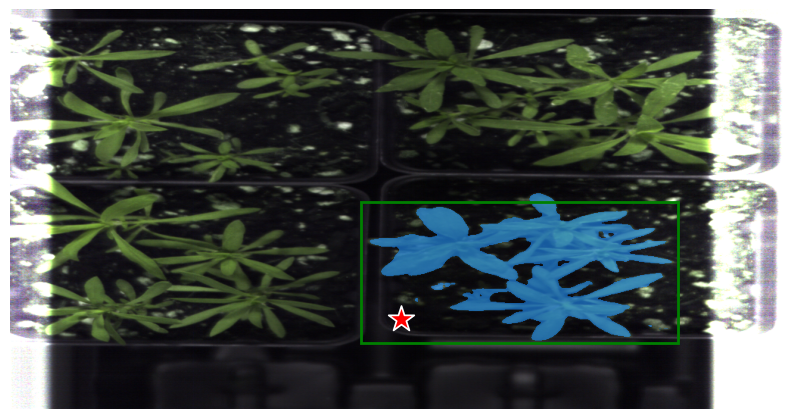

In [2222]:
input_box = np.array( [int(r[0]),int(r[1]), int(r[0]+r[2]), int(r[1]+r[3])])
input_point = np.array([[int(coordinates[0]), int(coordinates[1])]])
input_label = np.array([0])


# masks, _, _ = predictor.predict(
#     point_coords=None,
#     point_labels=None,
#     box=input_box[None, :],
#     multimask_output=False,
# )

# plt.figure(figsize=(10, 10))
# plt.imshow(pseudoimage)
# show_mask(masks[0], plt.gca())
# show_box(input_box, plt.gca())
# plt.axis('off')
# plt.show()


masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(pseudoimage)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point,input_label, plt.gca())
plt.axis('off')
plt.show()



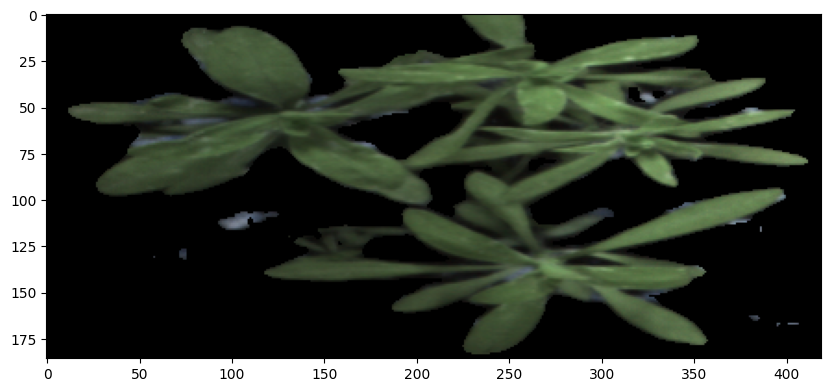

In [2223]:
calibrated_img=calibrated_img
masks = np.transpose(masks,(1,2,0))
masked_image = np.where(masks,calibrated_img,0)
masked_image_with_bg = calibrated_img[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])]
masked_image_without_bg = masked_image[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])]

pseudoRGB=np.stack([masked_image_without_bg[:,:,50],masked_image_without_bg[:,:,60],masked_image_without_bg[:,:,80]], axis =-1)
plt.figure(figsize=(10, 10))
plt.imshow(pseudoRGB)




In [2224]:
#kochia R
outputDIRbg ='/data/BillyGRam/Data/2022GH/Output_GH_Carrington/2022_GH_NDSU/Day1/KochiaR_withBG/'
outputDIRnobg ='/data/BillyGRam/Data/2022GH/Output_GH_Carrington/2022_GH_NDSU/Day1/KochiaR_withoutBG/'

np.save(outputDIRnobg + folder_name + "withoutBG.npy", masked_image_without_bg)
np.save(outputDIRbg + folder_name + "withBG.npy", masked_image_with_bg)

In [2225]:
%reset